
<p align="center">
    <img src="mosef.png" alt="MOSEF Logo" width="300">
</p>
```
</p>

<a href="https://linkedin.com/in/lucasvazelle">Vazelle Lucas  </a> $\cdot$ 
<a href="https://www.linkedin.com/in/mariam-tarverdian">Taverdian Mariam </a> $\cdot$ 2024-2025, MOSEF $\cdot$ 


---


- [Projet Kaggel ](https://www.kaggle.com/competitions/mosef-bank-churn-prediction/)


In [71]:
# Importer les dépendances
import pandas as pd
import numpy as np
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Modèles de machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Modèle de boosting
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# Pour le stacking
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier

# Explicabilité 
#import shap



# 0. Import data <a class="anchor" id="Introduction"></a>
---


In [339]:

train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print("Training Data:")
display(train.head())

print("Testing Data:")
display(test.head())

train.isnull().sum() # pas de na

train.dtypes# pas de surprises pour les types


Training Data:


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15713774.0,Hsieh,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0
1,1,15682533.0,Hs?eh,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0
2,2,15791550.0,Tsou,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0
3,3,15762762.0,Chiawuotu,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0
4,4,15756475.0,Nnamdi,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0


Testing Data:


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15797736.0,Chikwendu,591.0,Germany,Female,32.0,2.0,106881.50,2.0,1.0,0.0,122810.53
1,15001,15676515.0,Lai,553.0,Spain,Male,37.0,2.0,0.00,2.0,1.0,0.0,63736.17
2,15002,15701291.0,Folliero,646.0,France,Female,29.0,7.0,0.00,2.0,1.0,0.0,121866.87
3,15003,15594812.0,Trevisani,603.0,Germany,Male,49.0,8.0,131394.56,1.0,0.0,1.0,147059.28
4,15004,15791321.0,Ch'ien,645.0,Spain,Female,39.0,3.0,0.00,2.0,1.0,0.0,129975.94


id                   int64
CustomerId         float64
Surname             object
CreditScore        float64
Geography           object
Gender              object
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object

# 1. Traitement de la base de donnée <a class="anchor" id="Introduction"></a>
---


In [340]:
# Explcation des variables et plan de route

# 0. Si plusieurs observtion correspondent à la même personne et qu'il prends un gros poids, tout sera biaisé..il faut vérifier l'indépendances des observations

# 1. enlever variables d'informations inutiles OK

# 2. gérer muticolinéarité OK 

# 3. encoder variable Gender Age (one hot encoding ou autre) OK

# 4. Outlier OK

# 5. créer des variables pertinentes (min max,..) Non retenue

# 7. garder que colonnes que l'on comprends : RFE, BORUTA,.. Traité avec Multicolinéarité

# 8. CHoix métrique : AUC

#Liste des variables : 

# ID client : un identifiant unique pour chaque client

# Nom : Le nom ou prénom du client

# Score de crédit : une valeur numérique représentant le score de crédit du client

# Géographie : Le pays où réside le client (France, Espagne ou Allemagne)

# Sexe : Le sexe du client (homme ou femme)

# Âge : L'âge du client.

# Ancienneté : le nombre d'années pendant lesquelles le client est un client

# Solde : Le solde du compte du client

# NumOfProducts : Le nombre de produits bancaires utilisés par le client (par exemple, compte d'épargne, carte de crédit)

# HasCrCard : si le client possède une carte de crédit (1 = oui, 0 = non)

# IsActiveMember : si le client est un membre actif (1 = oui, 0 = non)

# Salaire estimé : Le salaire estimé du client

# Sortie : si le client a quitté le service (1 = oui, 0 = non)

## enlever les observations dépendantes

 Gestion des doublons

Pour les doublons identifiés dans les données, nous appliquons les règles suivantes :

1. Pour les doublons ayant les mêmes `CustomerID`, `Surname`, `Gender` et `Geography`, nous gardons l'observation avec l'`Age` le plus élevé afin d'avoir l'observation la plus récente.
2. Pour les doublons ayant les mêmes `CustomerID`, `Surname` et `Gender`, nous gardons également l'observation avec l'`Age` le plus élevé, car il est probable qu'il s'agisse des mêmes individus ayant changé de domiciliation.
3. Pour les doublons ayant les mêmes `CustomerID`, `Surname` et `Geography`, nous conservons les deux observations, même si cela peut introduire un biais, car il n'est pas possible de définir une règle de dédoublonnage pertinente dans ce cas.
```

In [341]:
train_traitement = train
#train_traitement.drop_duplicates(["CustomerId"]).count()
# énormément de doublons, le costumumer id est vraiment un identifiant unique ?

In [342]:
duplicate_groups = train_traitement[train_traitement.duplicated(subset=['CustomerId'], keep=False)].sort_values(by='CustomerId')
#duplicate_groups
# Le costumerID n'est pas pertinent

In [343]:
# traitenemnt surname
error_surnames = [surname for surname in list(train_traitement.Surname.unique()) if "?" in surname or "'" in surname]
print("Surnames with errors:", error_surnames)
# Replace "?" with "i" and "'" with "" in surnames if the word does not start with "O"
train_traitement['Surname'] = train_traitement['Surname'].apply(lambda x: x.replace("?", "i").replace("'", "") if not x.startswith("O") else x)
print("Cleaned Surnames:", list(train_traitement['Surname'].unique()))


Surnames with errors: ['Hs?eh', "O'Donnell", "P'eng", 'Hs?', 'H?', "Ch'en", 'Y?an', 'K?', 'L?', "T'ang", "Ts'ui", "Ch'in", "Ch'eng", "T'ien", "Ch'ien", "Ts'ai", "P'an", "Ch'ang", "O'Brien", "T'ao", "Ch'iu", "K'ung", "Ts'ao", "O'Loughlin", "O'Loghlin", "O'Sullivan", 'Y?', "T'an", "O'Callaghan", "O'Loghlen", "Ch'ao", "O'Connor", "O'Toole", "O'Meara", "O'Neill", "D'Albertis", 'H?an']
Cleaned Surnames: ['Hsieh', 'Tsou', 'Chiawuotu', 'Nnamdi', 'Cremonesi', 'Chiu', 'Mackenzie', 'Brient', "O'Donnell", 'Nnaemeka', 'Chimezie', 'Peng', 'Lettiere', 'Hsi', 'Nnamutaezinwa', 'Chia', 'Kambinachi', 'Obielumani', 'Iloerika', 'Tseng', 'Hi', 'Chukwuemeka', 'Chiagoziem', 'Mancini', 'Chidiegwu', 'Folliero', 'Hsia', 'Chibueze', 'Pinto', 'Echezonachukwu', 'Chidumaga', 'Frolov', 'Chiang', 'Chen', 'Ritchie', 'Wright', 'McIntosh', 'Chiemela', 'Lucciano', 'Yian', 'Maclean', 'Chukwubuikem', 'Onwuamaeze', 'Pagnotto', 'Lu', 'Lo Duca', 'Ki', 'Dyer', 'Mazzi', 'Onyemauchechukwu', 'Eames', 'Ma', 'Hao', 'Horsley', 'Hsiu

In [344]:
# duplicate_groups = train[train.duplicated(subset=['CustomerId',"Surname", "Gender", "Geography"], keep=False)].sort_values(by='CustomerId')
# display(duplicate_groups)
# # observation des cas de figures

In [345]:
# Pour les doublons ayant les mêmes "CustomerID", "Surname", "Gender" et "Geography", on garde l'observation avec l'"Age" le plus élevé
train_traitement = train_traitement.sort_values('Age').drop_duplicates(subset=['CustomerId', 'Surname', 'Gender', 'Geography'], keep='last')

# Pour les doublons ayant les mêmes "CustomerID", "Surname" et "Gender", on garde l'observation avec l'"Age" le plus élevé
train_traitement = train_traitement.sort_values('Age').drop_duplicates(subset=['CustomerId', 'Surname', 'Gender'], keep='last')

# Afficher le nombre d'observations après suppression des doublons
print("Nombre d'observations après suppression des doublons:", len(train_traitement))

Nombre d'observations après suppression des doublons: 14923


## enlever les variables inutiles

In [346]:
train_traitement = train.drop(columns=['Surname', 'id', 'CustomerId'])
# variables non pertinentes

In [347]:
train_traitement = train_traitement.drop_duplicates()
train_traitement.count()
# pas de doublons parfait 

CreditScore        15000
Geography          15000
Gender             15000
Age                15000
Tenure             15000
Balance            15000
NumOfProducts      15000
HasCrCard          15000
IsActiveMember     15000
EstimatedSalary    15000
Exited             15000
dtype: int64

## multicolinéarité

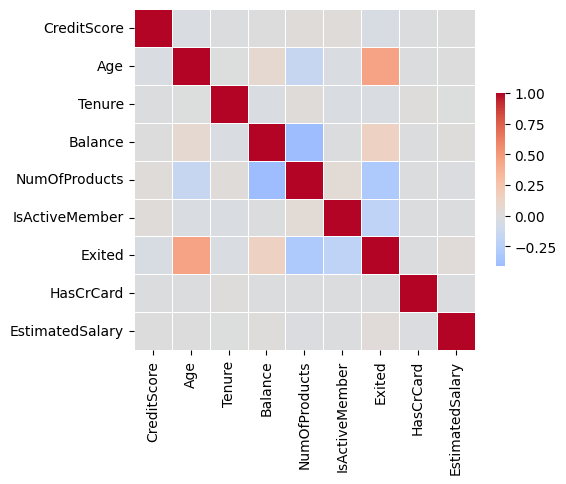

In [348]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt

categorical_columns = ['Gender', 'Geography']
correlation_matrix = train_traitement.drop(columns=categorical_columns).corr()
distance_matrix = 2 * (1 - np.abs(correlation_matrix))
clustering = AgglomerativeClustering(n_clusters=3, linkage='single', metric="precomputed").fit(distance_matrix)
clusters = [list(correlation_matrix.columns[clustering.labels_ == lab]) for lab in set(clustering.labels_)]
reordered = np.concatenate(clusters)
R = correlation_matrix.loc[reordered, reordered]
f, ax = plt.subplots(figsize=(5.5, 4.5))
_ = sns.heatmap(R, cmap='coolwarm', vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [349]:
# enlève colonne balance car elle est très corrélé avec Nombre de produit mais nombre de produit est plus corrélé avec la target que Balance
# train_traitement = train_traitement.drop(columns=['Balance'])
# on va laisser le modèle gérer le choix entre la variable Blance et NumOfppRODUCT

## Outlier 

### solution 1 (retenu) : distance de cook

In [350]:

class OutlierCooksDistance:
    def __init__(self, donnees: pd.DataFrame, variable_cible: str) -> None:
        self.donnees = donnees
        self.variable_cible = variable_cible
        self.colonnes_numeriques = donnees.select_dtypes(include=['float64', 'int64']).columns
        self.colonnes_categorielles = donnees.select_dtypes(include=['object']).columns
        self.variables_features = self.colonnes_numeriques.drop(variable_cible)
        self.X_features_numeriques = self.donnees[self.variables_features]
        self.y_cible = self.donnees[self.variable_cible]
        self.X_features_avec_constante = sm.add_constant(self.X_features_numeriques)

    def ajuster_modele_logistique(self):
        self.modele_logistique = sm.Logit(self.y_cible, self.X_features_avec_constante)
        self.modele_logistique_ajuste = self.modele_logistique.fit()

    def calculer_distances_cook(self):
        influence = self.modele_logistique_ajuste.get_influence()
        self.distances_cook = influence.cooks_distance[0]

    def identifier_outliers(self):
        nombre_observations = len(self.donnees)
        nombre_parametres = self.X_features_avec_constante.shape[1]
        seuil_distance_cook = 4 / (nombre_observations - nombre_parametres)
        self.outliers = np.where(self.distances_cook > seuil_distance_cook)[0]

    def supprimer_outliers(self) -> pd.DataFrame:
        if len(self.outliers) > 0:
            print(f"Indices des outliers détectés : {self.outliers}")
        # Utiliser errors='ignore' pour éviter les erreurs KeyError
            self.donnees_sans_outliers = self.donnees.drop(index=self.outliers, errors='ignore')
        else:
          print("Aucun outlier détecté. Pas de suppression d'observations.")
          self.donnees_sans_outliers = self.donnees
        return self.donnees_sans_outliers
    def tracer_distance_cook(self):
        plt.figure(figsize=(10, 6))
        plt.stem(np.arange(len(self.distances_cook)), self.distances_cook, markerfmt=",")
        plt.title("Distance de Cook pour chaque observation")
        plt.xlabel("Index de l'observation")
        plt.ylabel("Distance de Cook")
        plt.show()
data = train_traitement
variable_cible = 'Exited'
traitement = OutlierCooksDistance(data, variable_cible)

# # Étapes de traitement
# traitement.ajuster_modele_logistique()
# traitement.calculer_distances_cook()
# traitement.identifier_outliers()
# data_train_sans_outlier = traitement.supprimer_outliers()
# traitement.tracer_distance_cook()

# # Affichage du nombre d'observations supprimées
# print(f"Nombre d'observations supprimées : {len(train_traitement) - len(data_train_sans_outlier)}")


### Solution 2 (non retenu): RobustScaler

In [351]:

# # Charger la table data_traitement
# # Remplacez "data_traitement.csv" par la source de vos données
# data = train_traitement

# # Initialiser le scaler
# scaler = RobustScaler()

# # Sélectionner les colonnes numériques pour le scaling
# numeric_cols = data.drop(columns=["Exited"]).select_dtypes(include=['float64', 'int64']).columns

# # Appliquer le scaling uniquement sur les colonnes numériques
# data_scaled = data.copy()
# data_scaled[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# data_traitement = data_scaled

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Comparaison avant et après scaling
# for col in numeric_cols:
#     plt.figure(figsize=(10, 4))
#     sns.kdeplot(data[col], label="Original", shade=True)
#     sns.kdeplot(data_scaled[col], label="Scaled", shade=True)
#     plt.title(f"Distribution de la colonne {col}")
#     plt.legend()
#     plt.show()


## Traitement catégorielles 

In [352]:
train_traitement = pd.get_dummies(train_traitement, columns=['Gender', 'Geography'], drop_first=False)*1
# pas de drop first sauf si on utilise la regression logistique

## Ajoute nouvelles colonnes pertinentes

Idées: 
Age            
Tenure             
Balance           
NumOfProducts      
HasCrCard        
IsActiveMember    
EstimatedSalary    

## Traitement table de test

In [353]:
test_traitement = test.drop(columns=['Surname', 'id', 'CustomerId', 'Balance'])
test_traitement = pd.get_dummies(test_traitement, columns=['Gender', 'Geography'], drop_first=False)*1


# 2. Modélisation <a class="anchor" id="Introduction"></a>
---


In [354]:
X = train_traitement.drop(columns=['Exited'])
y = train_traitement['Exited']

## 2.1 Modèle regression linéaire (non retenu) <a class="anchor" id="Introduction"></a>
---


In [ ]:
# import statsmodels.api as sm

# X = train_traitement.drop(columns=['Exited'])
# y = train_traitement['Exited']
    
# # Add a constant to the model
# X = sm.add_constant(X)

# # Fit the logistic regression model
# logit_model = sm.Logit(y, X).fit()

# # Print the summary of the model
# print(logit_model.summary())



Optimization terminated successfully.
         Current function value: 0.319142
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14989
Method:                           MLE   Df Model:                           10
Date:                Sun, 10 Nov 2024   Pseudo R-squ.:                  0.3610
Time:                        16:29:01   Log-Likelihood:                -4787.1
converged:                       True   LL-Null:                       -7492.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.7432      0.299    -12.531      0.000      -4.329      -3.158
CreditSc

## 2.2 Modèle GradientBoosting <a class="anchor" id="Introduction"></a> (modèle retenu)
---


In [355]:
gbc = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

gbc.fit(X, y)

models = [gbc]
results = {}
for model in models:
    cv_results = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    results[model] = cv_results
    print(f'{model} - Mean AUC: {cv_results.mean()}')
    print(f'CV AUC scores: {cv_results}')


GradientBoostingClassifier(random_state=123) - Mean AUC: 0.9365232846652315
CV AUC scores: [0.93081434 0.94189137 0.9412923  0.93419642 0.93442198]


## 2.3 Modèle ADAM (non retenu)
---


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam

# # Define the model
# model = Sequential()
# model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model with Adam optimizer
# adam = Adam(learning_rate=0.1)  # Set learning_rate to 0.1 as specified
# model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# # Train the model with mini-batch gradient descent
# model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1, verbose=0)

# # Evaluate the model
# loss, accuracy = model.evaluate(X, y)
# print(f"Accuracy: {accuracy}")


# # Predict on the test set
# test_predictions = model.predict(test_traitement)
# print(test_predictions)

c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7969 - loss: 0.5048  
Accuracy: 0.8006666898727417
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[0.2110749]
 [0.2110749]
 [0.2110749]
 ...
 [0.2110749]
 [0.2110749]
 [0.2110749]]


## 2.4 Modèle stacking (non retenu)
---


In [ ]:


# # Définir les modèles de base
# base_learners = [
#     ('gb', GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
#                                       learning_rate=0.1, loss='log_loss', max_depth=3,
#                                       max_features=None, max_leaf_nodes=None,
#                                       min_impurity_decrease=0.0, min_samples_leaf=1,
#                                       min_samples_split=2, min_weight_fraction_leaf=0.0,
#                                       random_state=123, subsample=1.0, tol=0.0001,
#                                       validation_fraction=0.1, verbose=0,
#                                       warm_start=False)),
#     ('LGBM', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
#                             device='gpu', importance_type='split', learning_rate=0.1,
#                             max_depth=-1, min_child_samples=20, min_child_weight=0.001,
#                             min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
#                             objective=None, random_state=123, reg_alpha=0.0, reg_lambda=0.0,
#                             subsample=1.0, subsample_for_bin=200000, subsample_freq=0))]

# # Définir un meilleur modèle de meta
# meta_model = LogisticRegression()

# # Construire un modèle de stacking
# stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=StratifiedKFold(n_splits=5))

# # Entraîner le modèle
# stacking_model.fit(X, y)

# # Prédictions et évaluation
# y_pred_stack = stacking_model.predict(X)
# y_prob_stack = stacking_model.predict_proba(X)[:, 1]

# # Calculer l'AUC
# auc_stack = roc_auc_score(y, y_prob_stack)
# print('AUC Stacking:', auc_stack)

# # Afficher le classification report
# print('Classification Report Stacking:')
# print(classification_report(y, y_pred_stack))

# # Cross-validation pour l'AUC avec StratifiedKFold
# cv_auc_scores = cross_val_score(stacking_model, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
# print(f'CV AUC scores: {cv_auc_scores}')
# print(f'Mean AUC from CV: {np.mean(cv_auc_scores)}')


[LightGBM] [Info] Number of positive: 2990, number of negative: 12010
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 13
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.11 MB) transferred to GPU in 0.002060 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199333 -> initscore=-1.390466
[LightGBM] [Info] Start training from score -1.390466
[LightGBM] [Info] Number of positive: 2392, number of negative: 9608
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Info] Using G

#   3. Explicabilité du modèle
---


In [ ]:
# !pip install shap

  Using cached shap-0.46.0-cp310-cp310-win_amd64.whl (456 kB)
  Using cached llvmlite-0.43.0-cp310-cp310-win_amd64.whl (28.1 MB)
  Using cached numpy-2.0.2-cp310-cp310-win_amd64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sktime 0.26.0 requires numpy<1.27,>=1.21, but you have numpy 2.0.2 which is incompatible.
sktime 0.26.0 requires pandas<2.2.0,>=1.1, but you have pandas 2.2.3 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# # Initialiser l'explainer SHAP
# import shap
# explainer = shap.Explainer(gbc, X)

# # Calculer les valeurs SHAP pour l'ensemble de test
# shap_values = explainer(test_traitement)

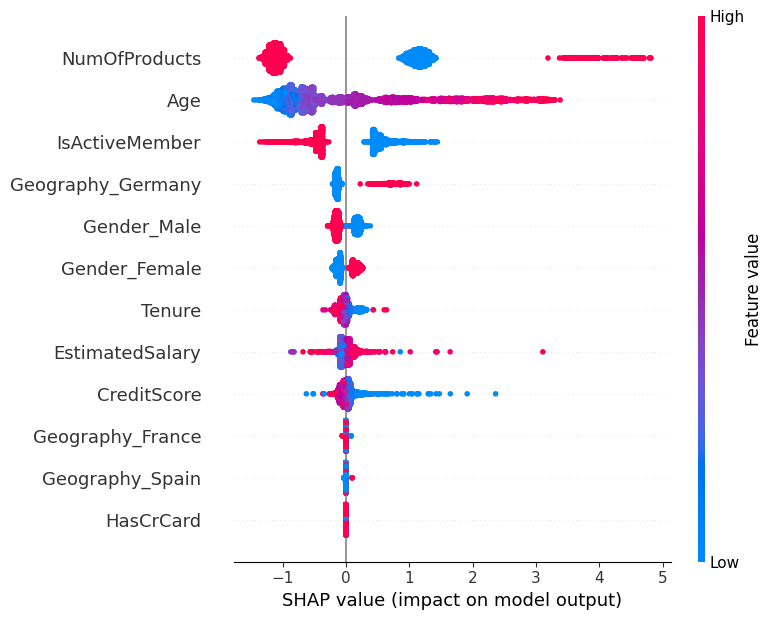

In [ ]:
# shap.summary_plot(shap_values, test_traitement)


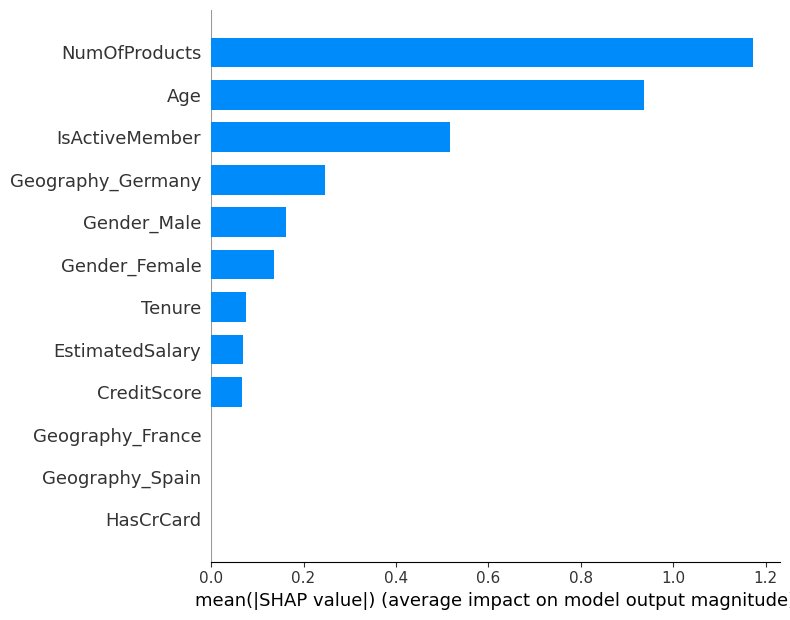

In [ ]:
# shap.summary_plot(shap_values, test_traitement, plot_type="bar")


Observation 1 (index 1109):


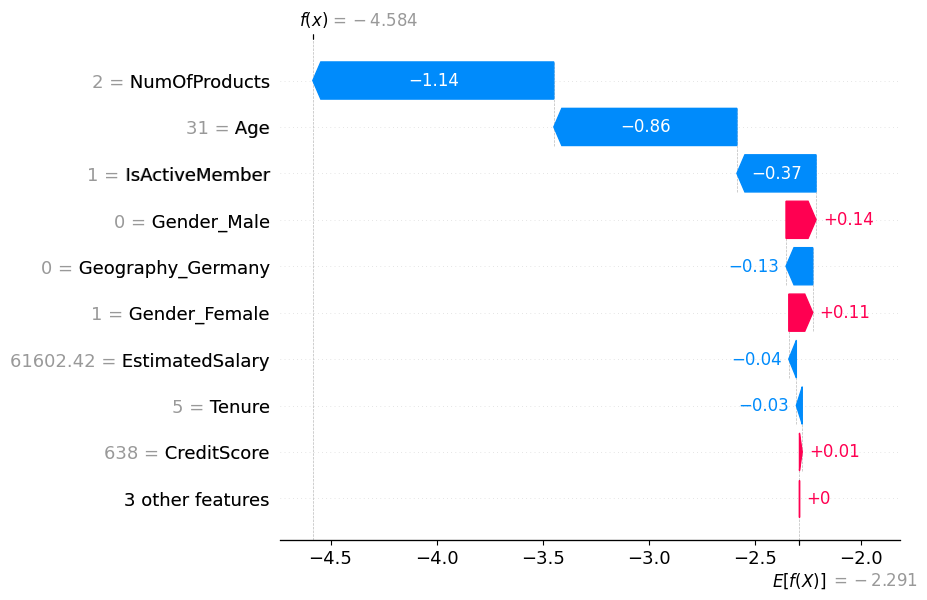

Observation 2 (index 7913):


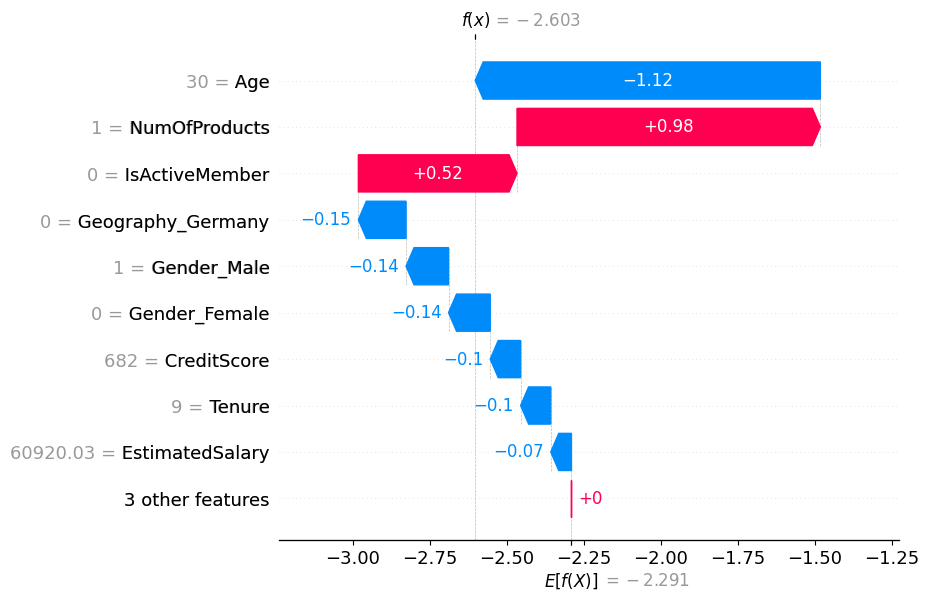

Observation 3 (index 612):


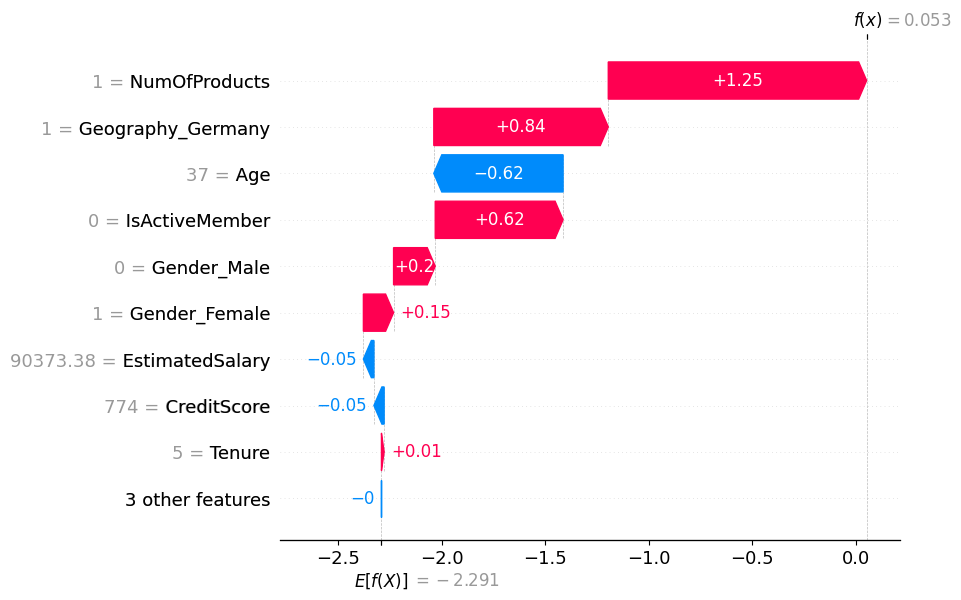

Observation 4 (index 1256):


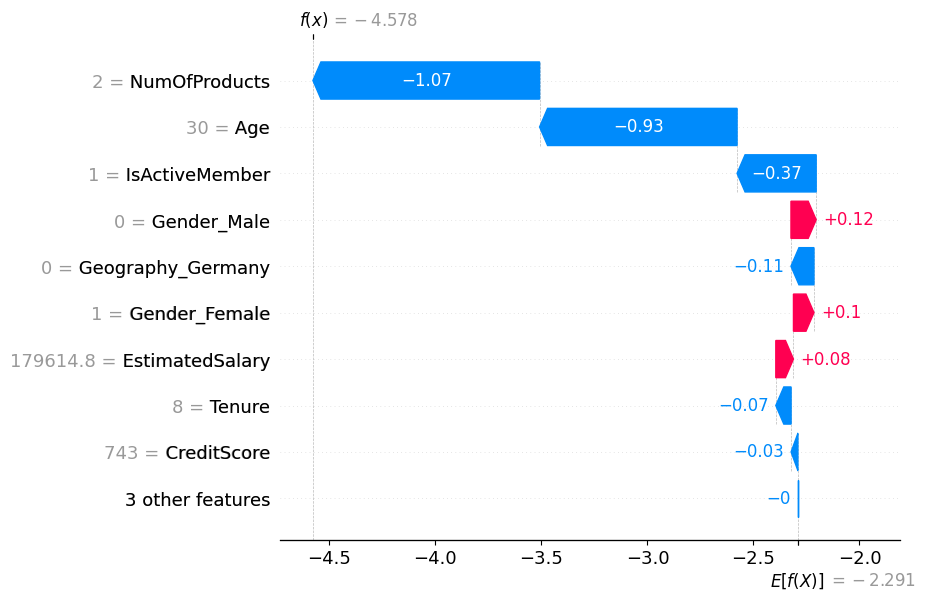

Observation 5 (index 4619):


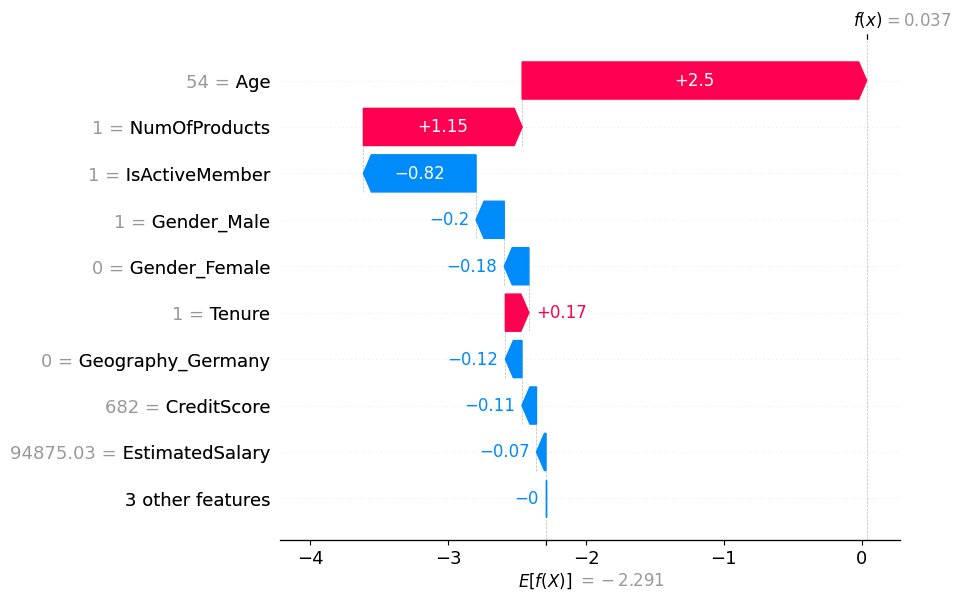

In [ ]:
# import random

# random_indices = random.sample(range(len(shap_values)), 5)

# # Générer les explications pour 5 observations
# for i, index in enumerate(random_indices):
#     print(f"Observation {i+1} (index {index}):")
#     shap.plots.waterfall(shap_values[index])

# 4. Prediction <a class="anchor" id="Introduction"></a>
---

In [137]:
modele_choisi = gbc

In [142]:
# Get the predicted probabilities
test_predictions_proba = modele_choisi.predict_proba(test_traitement)[:, 1]

# Display the predicted probabilities
print(test_predictions_proba)

[0.06399164 0.0183873  0.01755508 ... 0.01697062 0.09680013 0.29280655]


In [143]:
# Create a new dataframe with 'id' and 'test_predictions'
test_predictions_df = pd.DataFrame({'id': test['id'], 'Predictions': test_predictions_proba})

# Display the new dataframe
print(test_predictions_df.head())

      id  Predictions
0  15000     0.063992
1  15001     0.018387
2  15002     0.017555
3  15003     0.614856
4  15004     0.036294


In [49]:
# Save the test_predictions_df to a CSV file
test_predictions_df.to_csv('test_predictions.csv', index=False)